Question3 With Selection Bias

In [4]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import matplotlib.pyplot as plt
from linearmodels import IV2SLS
from tqdm import tqdm
random.seed(42)

In [5]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import graphviz as gr
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("fivethirtyeight")

# DAG without selection bias

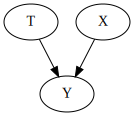

In [6]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X", "Y")

g

# DAG with selection bias

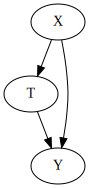

In [7]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X", "Y")
g.edge("X", "T")

g

# Randomized Experiment without controlling selection bias
 $ Y = \tau * T + X @ \beta +  err$

In [8]:
def generate_cov(dim, corr):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc, axis=0)


def generate_multnorm(nobs, corr, nvar):
    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc=1, scale=.5, size=(nvar, 1)))) ** (1 / 2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i], std[i], nobs), (nobs, -1)))

    normvars = np.concatenate(acc, axis=1)

    cov = generate_cov(nvar, corr)
    C = np.linalg.cholesky(cov)

    X = np.transpose(np.dot(C, np.transpose(normvars)))
    return X


def randomize_treatment(N, prob=0.5):
    return np.random.binomial(1, prob, N).reshape([N, 1])


def generate_data(tau, N, p, corr=0.5):
    """p is the number of covariates"""
    X = generate_multnorm(N, corr, p)
    T = randomize_treatment(N) 
    err = np.random.normal(0, 1, [N, 1])
    beta = np.random.normal(5, 5, [p, 1])

    Y = tau * T + X @ beta +  err
    return Y, T, X


def randomized_experiment(tau, N, p, violate=False):
    """
    :param violate: boolean, whether the DGP violates the assumptions: covariates correlate with the treatment
    :return: estimate of the treatment effect and the standard error of it
    """
    Y, T, X = generate_data(tau, N, p)
    if violate:
        T = np.zeros([N, 1])
        T[X[:, 0] > 0] = 1
    covars = np.concatenate([T, X], axis=1)
    mod = sm.OLS(Y, covars)
    res = mod.fit()
    tauhat = res.params[0]
    se_tauhat = res.HC1_se[0]
    return tauhat, se_tauhat


def get_bias_rmse_size(true_value, estimate: list, standard_error: list, cval = 1.96):
    R = len(estimate)
#     estimate = np.array(estimate).reshape([R, 1])
#     standard_error = np.array(standard_error).reshape([R, 1])
    b = estimate - np.ones([R, 1]) * true_value
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b ** 2))
    tval = b / standard_error
    size = np.mean(1 * (np.abs(tval) > cval))
    return bias, rmse, size

In [9]:
N = 1000  # number of observations
tau = 5  # treatment effect
p = 10  # number of covariates
R = 500  # number of experiments

In [10]:
# This is the case when the assumption holds
tauhats = []
se_tauhats = []
for _ in tqdm(range(R)):
    tauhat, se_tauhat = randomized_experiment(tau, N, p, violate=False)
    tauhats.append(tauhat)
    se_tauhats.append(se_tauhat)
    
tauhats = np.array(tauhats).reshape([R, 1])
se_tauhats = np.array(se_tauhats).reshape([R, 1])
print("Average estimate value and standard error are:", tauhats.mean(), se_tauhats.mean())

bias, rmse, size = get_bias_rmse_size(tau, tauhats, se_tauhats)
print("bias, rmse, size are:", round(bias, 4), round(rmse, 4), round(size, 4))

100%|██████████| 500/500 [00:00<00:00, 792.20it/s]

Average estimate value and standard error are: 5.0027387703960375 0.044843500030644794
bias, rmse, size are: 0.0027 0.0453 0.05


In [ ]:
N = 100  # number of observations
tau = 5  # treatment effect
p = 10  # number of covariates
R = 500  # number of experiments
# This is the case when the assumption holds
tauhats = []
se_tauhats = []
for _ in tqdm(range(R)):
    tauhat, se_tauhat = randomized_experiment(tau, N, p, violate=False)
    tauhats.append(tauhat)
    se_tauhats.append(se_tauhat)
    
tauhats = np.array(tauhats).reshape([R, 1])
se_tauhats = np.array(se_tauhats).reshape([R, 1])
print("Average estimate value and standard error are:", tauhats.mean(), se_tauhats.mean())

bias, rmse, size = get_bias_rmse_size(tau, tauhats, se_tauhats)
print("bias, rmse, size are:", round(bias, 4), round(rmse, 4), round(size, 4))

# Real World Example

# Randomized Experiment controlling selection bias


 $ Y = \tau * T + X @ \beta +  err$
 
 $ T = np.zeros([N, 1])
        T[X[:, 0] > 0] = 1 $

In [12]:
# This is the case when the assumption is violated
tauhats = []
se_tauhats = []
for _ in tqdm(range(R)):
    tauhat, se_tauhat = randomized_experiment(tau, N, p, violate=True)
    tauhats.append(tauhat)
    se_tauhats.append(se_tauhat)
    
tauhats = np.array(tauhats).reshape([R, 1])
se_tauhats = np.array(se_tauhats).reshape([R, 1])
print("Average estimate value and standard error are:", tauhats.mean(),se_tauhats.mean())

bias, rmse, size = get_bias_rmse_size(tau, tauhats, se_tauhats)
print("bias, rmse, size are:", round(bias, 4), round(rmse, 4), round(size, 4))

100%|██████████| 500/500 [00:00<00:00, 1445.71it/s]

Average estimate value and standard error are: 3.668684887088985 0.5090894264629022
bias, rmse, size are: -1.3313 1.4327 0.744


In [13]:
N = 100  # number of observations
tau = 5  # treatment effect
p = 10  # number of covariates
R = 500  # number of experiments
# This is the case when the assumption is violated
tauhats = []
se_tauhats = []
for _ in tqdm(range(R)):
    tauhat, se_tauhat = randomized_experiment(tau, N, p, violate=True)
    tauhats.append(tauhat)
    se_tauhats.append(se_tauhat)
    
tauhats = np.array(tauhats).reshape([R, 1])
se_tauhats = np.array(se_tauhats).reshape([R, 1])
print("Average estimate value and standard error are:", tauhats.mean(),se_tauhats.mean())

bias, rmse, size = get_bias_rmse_size(tau, tauhats, se_tauhats)
print("bias, rmse, size are:", round(bias, 4), round(rmse, 4), round(size, 4))

100%|██████████| 500/500 [00:00<00:00, 1358.64it/s]

Average estimate value and standard error are: 3.6618687201564772 0.5107662708152166
bias, rmse, size are: -1.3381 1.434 0.75


# Real World Example